In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [20]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

In [21]:
train_path= './ThermoDataBase/train'
test_path='./ThermoDataBase/val'

In [22]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen= image.ImageDataGenerator(   
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [23]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary')
validation_generator = val_datagen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 1445 images belonging to 2 classes.
Found 422 images belonging to 2 classes.


In [32]:
from tensorflow.keras.applications.resnet50 import ResNet50 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, Lambda
from keras.models import Model
base_model = PTModel(input_shape =  (224,224,3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 85s 1us/step 


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [33]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    steps_per_epoch= 50,
    callbacks=[checkpoint]
    )

/home/shubh/miniconda3/envs/ml/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1756060000.371810    1528 service.cc:152] XLA service 0x753bf8014fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756060000.375969    1528 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-24 18:26:40.768511: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756060002.474346    1528 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-08-24 18:26:44.117915: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5652', 8 bytes spill stores, 8 bytes spill loads

2025-08-24 18:26:44.118033: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_

 4/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - AUC: 0.7160 - Precision: 0.6771 - Recall: 0.8244 - accuracy: 0.7552 - loss: 0.6491

I0000 00:00:1756060009.248084    1528 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - AUC: 0.7771 - Precision: 0.6699 - Recall: 0.7381 - accuracy: 0.7158 - loss: 0.6986

2025-08-24 18:27:00.081161: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1747', 8 bytes spill stores, 8 bytes spill loads

2025-08-24 18:27:00.090012: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1747', 12 bytes spill stores, 12 bytes spill loads

2025-08-24 18:27:00.441053: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1747', 8 bytes spill stores, 8 bytes spill loads

2025-08-24 18:27:00.617810: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1747', 112 bytes spill stores, 112 bytes spill loads

2025-08-24 18:27:00.677364: I external/loc


Epoch 1: val_accuracy improved from -inf to 0.83649, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 300ms/step - AUC: 0.7812 - Precision: 0.6718 - Recall: 0.7420 - accuracy: 0.7193 - loss: 0.6921 - val_AUC: 0.9504 - val_Precision: 0.9946 - val_Recall: 0.7302 - val_accuracy: 0.8365 - val_loss: 0.4660
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - AUC: 0.8401 - Precision: 0.7169 - Recall: 0.8513 - accuracy: 0.7783 - loss: 0.5657
Epoch 2: val_accuracy did not improve from 0.83649
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - AUC: 0.8399 - Precision: 0.7183 - Recall: 0.8498 - accuracy: 0.7783 - loss: 0.5656 - val_AUC: 0.9244 - val_Precision: 0.8036 - val_Recall: 0.8929 - val_accuracy: 0.8057 - val_loss: 0.3723
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUC: 0.9008 - Precision: 0.8455 - Recall: 0.7964 - accuracy: 0.8222 - loss: 0.4065
Epoch 3: val_accuracy improved from 0.83649 to 0.84123, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - AUC: 0.9008 - Precision: 0.8460 - Recall: 0.7969 - accuracy: 0.8226 - loss: 0.4068 - val_AUC: 0.9228 - val_Precision: 0.9695 - val_Recall: 0.7579 - val_accuracy: 0.8412 - val_loss: 0.4167
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - AUC: 0.8578 - Precision: 0.8062 - Recall: 0.8081 - accuracy: 0.7980 - loss: 0.5032
Epoch 4: val_accuracy did not improve from 0.84123
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - AUC: 0.8578 - Precision: 0.8058 - Recall: 0.8082 - accuracy: 0.7978 - loss: 0.5033 - val_AUC: 0.9200 - val_Precision: 0.7143 - val_Recall: 0.9722 - val_accuracy: 0.7512 - val_loss: 0.5122
Epoch 5/15
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - AUC: 0.9362 - Precision: 0.8756 - Recall: 0.8641 - accuracy: 0.8598 - loss: 0.3222
Epoch 5: val_accuracy improved from 0.84123 to 0.85545, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - AUC: 0.9358 - Precision: 0.8753 - Recall: 0.8632 - accuracy: 0.8593 - loss: 0.3231 - val_AUC: 0.9422 - val_Precision: 0.8930 - val_Recall: 0.8611 - val_accuracy: 0.8555 - val_loss: 0.2937
Epoch 6/15
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.9139 - Precision: 0.8592 - Recall: 0.8357 - accuracy: 0.8352 - loss: 0.3952
Epoch 6: val_accuracy did not improve from 0.85545
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - AUC: 0.9128 - Precision: 0.8595 - Recall: 0.8358 - accuracy: 0.8358 - loss: 0.3964 - val_AUC: 0.9341 - val_Precision: 0.9503 - val_Recall: 0.6825 - val_accuracy: 0.7891 - val_loss: 0.4682
Epoch 7/15
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - AUC: 0.9641 - Precision: 0.9653 - Recall: 0.8623 - accuracy: 0.9031 - loss: 0.2620
Epoch 7: val_accuracy improved from 0.85545 to 0.90284, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - AUC: 0.9625 - Precision: 0.9607 - Recall: 0.8616 - accuracy: 0.9011 - loss: 0.2655 - val_AUC: 0.9599 - val_Precision: 0.9774 - val_Recall: 0.8571 - val_accuracy: 0.9028 - val_loss: 0.2780
Epoch 8/15
10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - AUC: 0.9160 - Precision: 0.5914 - Recall: 0.9179 - accuracy: 0.7627 - loss: 0.6031

/home/shubh/miniconda3/envs/ml/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_accuracy did not improve from 0.90284
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - AUC: 0.9154 - Precision: 0.6844 - Recall: 0.8991 - accuracy: 0.8022 - loss: 0.4694 - val_AUC: 0.9510 - val_Precision: 0.9435 - val_Recall: 0.8611 - val_accuracy: 0.8863 - val_loss: 0.2754
Epoch 9/15
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - AUC: 0.9167 - Precision: 0.8230 - Recall: 0.8806 - accuracy: 0.8476 - loss: 0.3659
Epoch 9: val_accuracy did not improve from 0.90284
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - AUC: 0.9168 - Precision: 0.8250 - Recall: 0.8791 - accuracy: 0.8476 - loss: 0.3660 - val_AUC: 0.9489 - val_Precision: 0.8621 - val_Recall: 0.8929 - val_accuracy: 0.8507 - val_loss: 0.2835
Epoch 10/15
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUC: 0.9249 - Precision: 0.8974 - Recall: 0.8305 - accuracy: 0.8561 - loss: 0.3527
Epoch 10: val_accuracy did not improve from 0.90284
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - AUC: 0.9248 - Precision: 0.8969 - Recall: 0.8304 - accuracy: 0.8557 

In [35]:
model.evaluate(validation_generator)

106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - AUC: 0.9485 - Precision: 0.9161 - Recall: 0.9213 - accuracy: 0.9068 - loss: 0.2952


[0.28084343671798706,
 0.900473952293396,
 0.9532445669174194,
 0.9375,
 0.8928571343421936]

In [36]:
model.evaluate(train_generator)

362/362 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - AUC: 0.9842 - Precision: 0.9752 - Recall: 0.9067 - accuracy: 0.9381 - loss: 0.1922


[0.18736477196216583,
 0.9425605535507202,
 0.986370861530304,
 0.9651669263839722,
 0.9185082912445068]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[0.99752456]]
THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: Diabetic


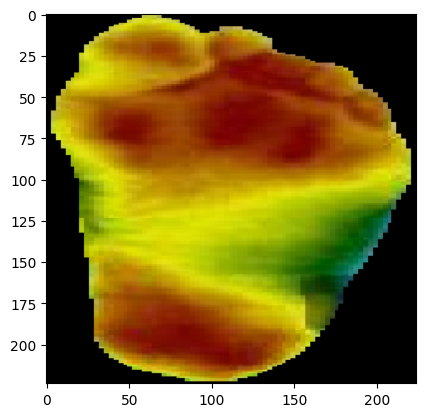

In [38]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('./ThermoDataBase/val/DM Group/DM004_M_L.png',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Normal"   
else:
      op="Diabetic"
plt.imshow(img)
print("THE UPLOADED THERMAL IMAGE IS SUSPECTED AS: "+str(op))

In [43]:
 model.save("./model.keras")